In [1]:
# !pip install torch
# !pip install torchvision

In [2]:
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

# Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


# Hyper Parameters

In [4]:
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

# Data Definition

In [5]:
transform = transforms.ToTensor()

In [6]:
train_set = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=False,
    transform=transform,
)

test_set = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=False,
    transform=transform,
)

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Architecture

In [8]:
class Autoencoder(nn.Module):
    """
    Encoder : (784) -> (128) -> (32)
    Decoder : (32) -> (128) -> (784)
    Sigmoid : 픽셀값을 [0,1]로 만들기 위해 사용
    """

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 32), nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 128), nn.ReLU(), nn.Linear(128, 28 * 28), nn.Sigmoid()
        )

    def forward(self, x):
        # x: [batch_size, 784]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Training

In [9]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for images, _ in train_loader:
        # MNIST 이미지는 [batch_size, 1, 28, 28] 형태
        # 오토인코더 입력을 위해 (batch_size, 784) 형태로 펼쳐줌
        images = images.view(images.size(0), -1).to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.0676
Epoch [2/10], Loss: 0.0324
Epoch [3/10], Loss: 0.0238
Epoch [4/10], Loss: 0.0200
Epoch [5/10], Loss: 0.0175
Epoch [6/10], Loss: 0.0159
Epoch [7/10], Loss: 0.0147
Epoch [8/10], Loss: 0.0138
Epoch [9/10], Loss: 0.0130
Epoch [10/10], Loss: 0.0123


# Evaluation

In [11]:
model.eval()

test_iter = iter(test_loader)
test_images, _ = next(test_iter)

## Results

In [12]:
# 샘플 8개만 확인
sample_images = test_images[:8].to(device)  # shape: [8, 1, 28, 28]
sample_images_flat = sample_images.view(8, -1)  # shape: [8, 784]

In [13]:
# 모델 복원
with torch.no_grad():
    reconstructed = model(sample_images_flat)  # shape: [8, 784]

In [14]:
# 모델의 복원 결과
with torch.no_grad():
    reconstructed = model(sample_images_flat)  # [8, 784]

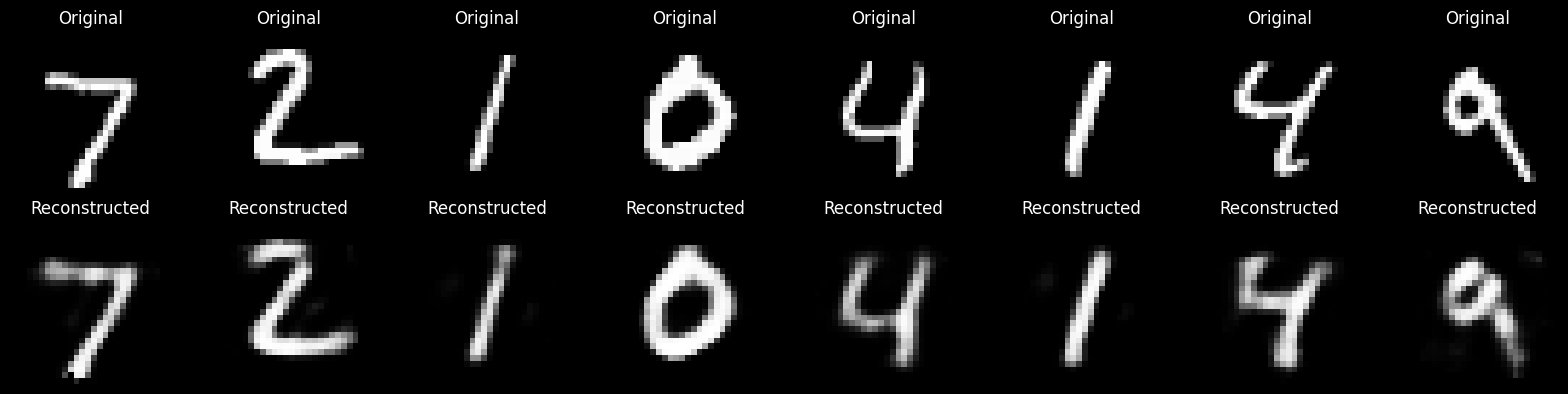

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))

for i in range(8):
    # 원본 이미지 (이미 [0,1] 범위이므로 그대로 사용)
    axes[0, i].imshow(
        sample_images[i].view(28, 28).numpy(), cmap="gray", vmin=0, vmax=1
    )
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # 복원된 이미지 ([0,1] 범위)
    axes[1, i].imshow(
        reconstructed[i].view(28, 28).numpy(), cmap="gray", vmin=0, vmax=1
    )
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

# End of Documents